#### **Теория**

1. **Центрирование данных** — это предварительная обработка данных, при которой из каждого значения признака (столбца матрицы) вычитается его среднее значение.
Формула: X(centr) = X - mean(X)




*  Х - исходная матрица данных (размер n х т, где п - число наблюдений, т - число признаков)
*  mean(X) - вектор средних значений по каждому столбцу

2. **Матрица ковариаций** — это квадратная матрица, которая показывает, как признаки (столбцы данных) изменяются вместе. Она используется для анализа взаимосвязей между переменными, например, в PCA (методе главных компонент).

* Формула матрицы ковариаций:
$$
\Sigma = \frac{1}{n - 1} X^\top X.
$$
X — центрированная матрица данных размерности n × m, а n — количество объектов.


3. Проекция данных — это преобразование исходных данных в новую систему координат, заданную главными компонентами. Формально, если W — матрица, столбцы которой являются собственными векторами ковариационной матрицы, то проекция данных вычисляется как:
 X(proj) = X(centr) * W


* X(centr) - Центрированная матрица данных (размер п Х m),
* W - матрица главных компонент (размер т × k, где k - число выбранных компонент),
* Х(ргоj) - спроецированные данные (размер п × k).
  Новый пункт

Чтобы узнать, какую долю данных мы сохранили с помощью k главных компонент, есть формула доли объяснённой дисперсии:
$$
\gamma = \frac{\sum_{i=1}^{k} \lambda_i}{\sum_{i=1}^{m} \lambda_i}.
$$



## Дополнительный класс

In [1]:
from typing import List, Tuple
import math

In [2]:
import csv
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

In [52]:
class Matrix:
    def __init__(self, data):
        # Проверяем, что данные представлены в виде непустого списка списков
        if not data or not isinstance(data, list) or any(not isinstance(r, list) for r in data):
            raise ValueError("Данные должны быть списком списков")
        # Проверяем одинаковую длину строк
        first_len = len(data[0])
        for r in data:
            if len(r) != first_len:
                raise ValueError("Все строки матрицы должны быть одной длины")
        # Копируем данные
        self.data = []
        for r in data:
            new_row = []
            for x in r:
                new_row.append(x)
            self.data.append(new_row)
        self.rows = len(self.data)
        self.cols = first_len

    def __add__(self, other):
        # Проверяем размерности
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError("Матрицы должны иметь одинаковые размеры")
        # Создаем пустую матрицу результатов
        result = Matrix([[0] * self.cols for _ in range(self.rows)])
        # Складываем поэлементно
        for i in range(self.rows):
            for j in range(self.cols):
                result.data[i][j] = self.data[i][j] + other.data[i][j]
        return result

    def __sub__(self, other):
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError("Матрицы должны иметь одинаковые размеры")
        result = Matrix([[0] * self.cols for _ in range(self.rows)])
        for i in range(self.rows):
            for j in range(self.cols):
                result.data[i][j] = self.data[i][j] - other.data[i][j]
        return result

    def __mul__(self, scalar):
        if not isinstance(scalar, (int, float)):
            raise TypeError("Можно умножать только на скаляр (int/float)")
        result = Matrix([[0] * self.cols for _ in range(self.rows)])
        for i in range(self.rows):
            for j in range(self.cols):
                result.data[i][j] = self.data[i][j] * scalar
        return result

    def __matmul__(self, other):
        if self.cols != other.rows:
            raise ValueError(
                "Количество столбцов первой матрицы должно совпадать с количеством строк второй"
            )
        # Результирующая матрица
        result = Matrix([[0] * other.cols for _ in range(self.rows)])
        # Тройной цикл умножения
        for i in range(self.rows):
            for j in range(other.cols):
                sum_val = 0
                for k in range(self.cols):
                    sum_val += self.data[i][k] * other.data[k][j]
                result.data[i][j] = sum_val
        return result

    def transpose(self):
        # Создаем пустую матрицу нужного размера
        transposed_data = [[0] * self.rows for _ in range(self.cols)]
        for i in range(self.rows):
            for j in range(self.cols):
                transposed_data[j][i] = self.data[i][j]
        return Matrix(transposed_data)

    def minor(self, i, j):
        if self.rows != self.cols:
            raise ValueError("Минор определен только для квадратных матриц")
        new_data = []
        for r in range(self.rows):
            if r == i:
                continue
            row_data = []
            for c in range(self.cols):
                if c == j:
                    continue
                row_data.append(self.data[r][c])
            new_data.append(row_data)
        return Matrix(new_data)

    def determinant_gauss(self) -> float:
        if self.rows != self.cols:
            raise ValueError("Детерминант определен только для квадратных матриц")
        # Копируем матрицу для работы
        mat = []
        for r in self.data:
            row_copy = []
            for x in r:
                row_copy.append(x)
            mat.append(row_copy)
        n = self.rows
        det = 1.0
        for p in range(n):
            # Находим опорный элемент
            pivot = p
            max_abs = abs(mat[p][p])
            for r in range(p+1, n):
                if abs(mat[r][p]) > max_abs:
                    max_abs = abs(mat[r][p])
                    pivot = r
            if max_abs < 1e-15:
                return 0.0
            if pivot != p:
                mat[p], mat[pivot] = mat[pivot], mat[p]
                det = -det
            pv = mat[p][p]
            det *= pv
            # Исключаем элементы ниже основной диагонали
            for r in range(p+1, n):
                factor = mat[r][p] / pv
                for c in range(p, n):
                    mat[r][c] -= factor * mat[p][c]
        return det

    def determinant(self):
        return self.determinant_gauss()

    def trace(self):
        total = 0
        for i in range(min(self.rows, self.cols)):
            total += self.data[i][i]
        return total

    def __getitem__(self, idx):
        if isinstance(idx, tuple):
            i, j = idx
            return self.data[i][j]
        return self.data[idx]

    def __str__(self):
        lines = []
        for r in self.data:
            row_str = []
            for x in r:
                row_str.append(str(x))
            lines.append(" ".join(row_str))
        return "\n".join(lines)

    def row(self, i):
        result = []
        for x in self.data[i]:
            result.append(x)
        return result

    def col(self, j):
        result = []
        for i in range(self.rows):
            result.append(self.data[i][j])
        return result

    def copy(self):
        copied = []
        for r in self.data:
            row_copy = []
            for x in r:
                row_copy.append(x)
            copied.append(row_copy)
        return Matrix(copied)

    def set(self, i, j, value):
        self.data[i][j] = value

    def swap_rows(self, r1, r2):
        self.data[r1], self.data[r2] = self.data[r2], self.data[r1]


## 1. Easy level

### 1.1 Задание: Реализовать метод Гаусса для решения СЛАУ:

Метод Гаусса — это метод для решения систем линейных алгебраических уравнений (СЛАУ), который основывается на преобразовании системы к верхнетреугольной матрице с помощью элементарных операций над строками.

**1. Прямой ход:**
- На каждом шаге выбираем ведущий элемент (пивот) в столбце.
- Меняем строки местами, если необходимо, чтобы элемент с максимальным абсолютным значением оказался на ведущей позиции.
- Приводим все элементы ниже ведущего элемента к нулю с помощью вычитания строк, умноженных на соответствующие коэффициенты.

**2. Проверка на несовместность:**
- Если после прямого хода получается строка вида [0, 0, ..., 0 | d], где d ≠ 0, система не имеет решений.

**3. Обратный ход:**
- Начинаем с последней строки и вычисляем значение переменных, подставляя уже найденные решения в предыдущие уравнения.

**4. Специфичные случаи:**
- **Несовместные системы**: Строка вида [0, 0, ..., 0 | d] где d ≠ 0 означает отсутствие решений.
- **Бесконечно много решений**: Строка вида [0, 0, ..., 0 | 0] указывает на бесконечность решений.

Алгоритм решения СЛАУ методом Гаусса имеет временную сложность ( O(n^3) ), где ( n ) — количество переменных.

In [5]:
def gauss_solver(A: 'Matrix', b: 'Matrix') -> List['Matrix']:
    """
    Решение СЛУ методом Гаусса (прямой и обратный ход).
    Вход:
      A: квадратная матрица коэффициентов (n×n)
      b: столбец свободных членов (n×1)
    Выход:
      [Matrix]: список с единственным решением в виде столбцового вектора
    Исключения:
      ValueError, если система несовместна
    """
    n = A.rows
    eps = 1e-10

    # Формируем расширенную матрицу M размера n×(n+1)
    M = [ [A[i, j] for j in range(n)] + [b[i, 0]]
          for i in range(n) ]

    # Прямой ход
    for k in range(n):
        # выбираем строку с наибольшим по модулю элементом в столбце k
        pivot = max(range(k, n), key=lambda r: abs(M[r][k]))
        if abs(M[pivot][k]) < eps:
            # столбец k практически нулевой — пропускаем
            continue
        # меняем местами текущую строку и pivot-строку
        if pivot != k:
            M[k], M[pivot] = M[pivot], M[k]
        # нормируем ведущий элемент до 1
        lead = M[k][k]
        M[k] = [val / lead for val in M[k]]
        # вычитаем текущую строку из всех нижестоящих
        for i in range(k+1, n):
            factor = M[i][k]
            if abs(factor) > eps:
                M[i] = [M[i][j] - factor * M[k][j] for j in range(n+1)]

    # Проверяем на несовместность: (0 ... 0 | d), d != 0
    for row in M:
        if all(abs(v) < eps for v in row[:-1]) and abs(row[-1]) > eps:
            raise ValueError("Система несовместна")

    # Обратный ход
    x = [0.0] * n
    for i in range(n-1, -1, -1):
        if abs(M[i][i]) < eps:
            continue
        rhs = row_val = M[i][n]
        # вычитаем вклад уже найденных x[j]
        for j in range(i+1, n):
            rhs -= M[i][j] * x[j]
        x[i] = rhs / M[i][i]

    # Возвращаем решение в виде списка из одного вектора-столбца Matrix
    return [Matrix([[val] for val in x])]


### 1.2. Задание: Реализовать функцию центрирования данных:

$$
X_{\text{centered}} = X - \text{mean}(X).
$$

In [6]:
def center_data(self) -> 'Matrix':
        """
        Возвращает центрированную версию текущей матрицы (n×m).
        Каждая колонка будет иметь среднее значение 0.

        Результат:
          Matrix размером n×m, в котором из каждого элемента
          вычтено среднее по соответствующему столбцу.
        """
        # Вычисляем количество строк и столбцов
        rows_count = self.rows
        cols_count = self.cols

        # Считаем средние по столбцам
        column_means = []
        for j in range(cols_count):
            col_sum = 0.0
            for i in range(rows_count):
                col_sum += self.data[i][j]
            column_means.append(col_sum / rows_count)

        # Создаем новую матрицу-результат
        centered = []
        for i in range(rows_count):
            row_centered = []
            for j in range(cols_count):
                # из каждого элемента вычитаем среднее столбца
                row_centered.append(self.data[i][j] - column_means[j])
            centered.append(row_centered)

        return Matrix(centered)

### 1.3. Задание: Вычислить матрицу ковариаций:

$$
C = \frac{1}{n-1} X^\top X.
$$

In [7]:
def covariance_matrix(X_centered: 'Matrix') -> 'Matrix':
    """
    Строит матрицу ковариаций для центрированных данных X_centered (n×m).
    Возвращает Matrix размера m×m, где элемент (i,j) равен
      1/(n-1) * sum_{k=0..n-1} X_centered[k,i] * X_centered[k,j]
    """
    # Определяем размеры
    num_rows = X_centered.rows
    num_cols = X_centered.cols

    # Транспонируем X_centered
    X_transposed = X_centered.transpose()

    # Формируем пустую матрицу результирующих ковариаций m×m
    cov_data = []
    for i in range(num_cols):
        row = []
        for j in range(num_cols):
            # вычисляем сумму произведений по всем строкам
            acc = 0.0
            for k in range(num_rows):
                # X_transposed[i,k] == X_centered[k,i]
                acc += X_transposed[i, k] * X_centered[k, j]
            # нормируем на (n-1)
            row.append(acc / (num_rows - 1))
        cov_data.append(row)

    return Matrix(cov_data)

## 2. Normal Level

### 2.1 Задание: Найти собственные значения матрицы методом бисекции


Метод бисекции используется для нахождения корней уравнения det(C - λI) = 0., где C — матрица, λ — собственные значения, а I — единичная матрица. Для нахождения всех собственных значений матрицы, выполняются следующие шаги:

1. **Оценка интервала методом Гершгорина**:
   Метод Гершгорина дает интервал [a, b], на котором находятся все собственные значения матрицы. Радиус окружности для строки i вычисляется как сумма абсолютных значений всех элементов в строке, не включая диагональный элемент:
   $$
   R_i = \sum_{j \neq i} |c_{ij}|
   $$
   Собственные значения лежат внутри интервала c_{ii} - R_{i}, c_{ii} + R_{i}.

2. **Поиск корней методом бисекции**:
   После получения интервала \( [a, b] \), метод бисекции используется для нахождения корней функции f(λ) = det(C - λI). Метод бисекции заключается в последовательном делении интервала пополам, пока не будет достигнута нужная точность.

3. **Вычисление детерминанта**:
   Для каждой итерации метода бисекции вычисляется детерминант матрицы C - λI. Для этого используются стандартные численные методы, такие как разложение по строкам.

Метод бисекции гарантированно находит корни, если функция непрерывна и меняет знак на интервале. Однако вычисление детерминанта может быть дорогим для больших матриц.

In [8]:
def bisection_method(func, a, b, epsilon):
    """
    Находит один корень func(x)=0 на [a, b] методом бисекции.
    Возвращает значение корня или None, если на отрезке нет смены знака.
    """
    left, right = a, b
    f_left, f_right = func(left), func(right)
    # Проверка наличия корня
    if f_left * f_right > 0:
        return None

    # Итерации до достижения требуемой точности
    while (right - left) > 2 * epsilon:
        mid = (left + right) / 2
        f_mid = func(mid)
        # Если достаточно близко к нулю, возвращаем mid
        if abs(f_mid) < 1e-14:
            return mid
        # Сужаем интервал
        if f_left * f_mid <= 0:
            right, f_right = mid, f_mid
        else:
            left, f_left = mid, f_mid
    # Возвращаем центр последнего отрезка
    return (left + right) / 2


def find_all_roots(func, a, b, epsilon, tol=1e-5, step=0.1):
    """
    Находит все корни func(x)=0 на [a, b].
    Разбивает интервал на куски длины step,
    на каждом проверяет смену знака и уточняет корень.
    """
    roots = []
    # Формируем точки разбиения
    pts = [a + i * step for i in range(int((b - a) / step) + 1)]
    if pts[-1] < b:
        pts.append(b)

    # Проверяем каждый соседний отрезок
    for start, end in zip(pts, pts[1:]):
        f_s, f_e = func(start), func(end)
        if f_s * f_e <= 0:
            r = bisection_method(func, start, end, epsilon)
            if r is None:
                continue
            # Проверка, что корень уникален
            if all(abs(r - existing) > tol for existing in roots):
                roots.append(r)
    # Сортируем и возвращаем
    roots.sort()
    return roots

In [9]:
def direct_det_func(C, x):
    """
    Вычисляет определитель матрицы (C - xI) без явной сборки нового массива.

    Аргументы:
      C: Matrix (n×n)
      x: число, вычитаемое из диагональных элементов
    Возвращает:
      float — det(C - xI)
    """
    # Делаем поверхностную копию матрицы, чтобы не менять исходную
    M = C.copy()
    size = M.rows

    # Вычитаем x из каждого диагонального элемента
    for idx in range(size):
        orig = M[idx, idx]
        M.set(idx, idx, orig - x)

    # Считаем детерминант получившейся матрицы
    return M.determinant()

In [10]:
def gershgorin_interval(C, eps=1e-6):
    """
    Находит оценочный интервал, содержащий все собственные
    значения матрицы C по теореме Гершгорина.
    """
    # Собираем границы дисков для каждой строки
    lower_bounds = []
    upper_bounds = []

    for i, row in enumerate(C.data):
        center = row[i]
        # сумма модулей внедиагональных элементов
        radius = 0.0
        for j, val in enumerate(row):
            if j != i:
                radius += abs(val)
        lower_bounds.append(center - radius)
        upper_bounds.append(center + radius)

    # Интервал от наименьшей нижней границы до наибольшей верхней
    interval_min = min(lower_bounds) - eps
    interval_max = max(upper_bounds) + eps
    return interval_min, interval_max

In [64]:
def find_eigenvalues(C: 'Matrix', tol: float = 1e-6) -> List[float]:
    """
    Вычисляет собственные значения матрицы C через поиск корней характеристического многочлена.

    Параметры:
        C: квадратная матрица (m×m)
        tol: допустимая погрешность вычислений

    Возвращает:
        Список собственных значений в порядке возрастания
    """
    # 1. Определяем интервал поиска через теорему Гершгорина
    lower_bound, upper_bound = gershgorin_interval(C, eps=tol)

    # 2. Оптимизируем шаг разбиения интервала
    interval_size = upper_bound - lower_bound
    step_size = max(interval_size * 0.001, tol * 10)

    # 3. Лямбда-функция для вычисления определителя
    det_function = lambda x: direct_det_func(C, x)

    # 4. Находим корни характеристического уравнения
    eigenvalues = find_all_roots(
        det_function,
        lower_bound,
        upper_bound,
        epsilon=tol,
        step=step_size,
        tol=tol
    )

    eigenvalues.sort()

    return eigenvalues

### 2.2. Задание: Найтисобственные векторы матрицы

$$
(C - \lambda I)v = 0.
$$

In [12]:
def find_eigenvectors(C: 'Matrix', eigenvalues: List[float]) -> List['Matrix']:
    """
    Находит собственные векторы для матрицы C при заданных
    собственных значениях методом решения однородных систем.

    Аргументы:
      C            — Matrix размера m×m
      eigenvalues  — список чисел (собственных значений)

    Возвращает:
      список объектов Matrix (каждый — столбцовый вектор m×1)
    """
    dim = C.rows
    vectors = []

    for lam in eigenvalues:
        # Копируем C и вычитаем λ на диагонали
        M = C.copy()
        for i in range(dim):
            M.set(i, i, M[i, i] - lam)

        # Формируем нулевой вектор правых частей
        zero_rhs = Matrix([[0.0] for _ in range(dim)])

        # Решаем однородную систему (столбец-решение)
        sol_list = gauss_solver(M, zero_rhs)
        # Берем первый (и единственный) вектор из результата
        vectors.append(sol_list[0])

    return vectors


### 2.3. Задание : Вычислить долю объяснённой дисперсии:

$$
\gamma = \frac{\sum_{i=1}^{k} \lambda_i}{\sum_{i=1}^{m} \lambda_i}.
$$

In [13]:
def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:
    """
    Вычисляет долю дисперсии, объясняемую первыми k компонентами.

    Аргументы:
      eigenvalues — непустой список вещественных собственных значений
      k           — количество главных компонент (1 ≤ k ≤ len(eigenvalues))

    Возвращает:
      float — отношение суммы k наибольших собственных значений к общей сумме
    """
    count = len(eigenvalues)
    if count == 0:
        raise ValueError("Нет собственных значений для расчёта")
    if k < 1 or k > count:
        raise ValueError(f"Значение k должно быть от 1 до {count}, получено {k}")

    # Сумма всех собственных значений
    total_variance = 0.0
    for val in eigenvalues:
        total_variance += val
    if abs(total_variance) < 1e-15:
        raise ValueError("Нулевая общая дисперсия, деление невозможно")

    # Находим k крупнейших значений без изменения исходного списка
    # Простейший подход — копирование и сортировка
    temp = eigenvalues.copy()
    temp.sort(reverse=True)

    # Сумма объяснённой дисперсии по первым k
    explained_sum = 0.0
    for idx in range(k):
        explained_sum += temp[idx]

    # Доля объяснённой дисперсии
    ratio = explained_sum / total_variance
    return ratio

## 3. Hard Level + 4. Expert level

### 4.1 Задание (Expert): Добавить автоматический выбор числа главных компонент

$$
k = \min \left\{ k : \frac{\sum_{i=1}^{k} \lambda_i}{\sum_{i=1}^{m} \lambda_i} \ge \text{threshold} \right\}.
$$

In [14]:
def auto_select_k(eigenvalues: List[float], threshold: float = 0.95) -> int:
    """
    Выбирает число компонент k так, чтобы накопленная дисперсия
    достигала заданного порога.

    Аргументы:
      eigenvalues — список собственных значений
      threshold   — целевое отношение объяснённой дисперсии (0 < threshold ≤ 1)

    Возвращает:
      k — минимальное число компонент, при котором отношение
          объяснённой дисперсии ≥ threshold
    """
    # Проверяем входные данные
    count = len(eigenvalues)
    if count == 0:
        raise ValueError("Нет собственных значений для выбора k")
    if threshold <= 0 or threshold > 1:
        raise ValueError(f"Порог должен лежать в (0,1], получен {threshold}")

    # Считаем сумму всех собственных значений
    total_sum = 0.0
    for val in eigenvalues:
        total_sum += val
    if abs(total_sum) < 1e-14:
        raise ValueError("Общая дисперсия равна нулю, нормировка невозможна")

    # Накопленный счётчик дисперсии
    cumulative = 0.0
    # Проходим по всем собственным значениям последовательно
    for index in range(count):
        cumulative += eigenvalues[index]
        current_ratio = cumulative / total_sum
        # Как только достигнут порог — возвращаем текущее число компонент
        if current_ratio >= threshold:
            # index отсчитывает от 0, поэтому +1
            return index + 1

    # Если даже все компоненты не покрыли порог, возвращаем максимум
    return count

### 4.2 Задание (Expert): Обработать пропущенные значения в данных

$$
X_{\text{filled}} = \begin{cases}
X_{ij}, & \text{если } X_{ij} \neq \text{NaN}, \\
\text{mean}(X_j), & \text{иначе}.
\end{cases}
$$

In [15]:
def handle_missing_values(X: 'Matrix') -> 'Matrix':
    """
    Заменяет пропущенные значения NaN в матрице X
    на среднее по соответствующему столбцу.

    Аргументы:
      X — Matrix размера n×m, содержащая float и NaN
    Возвращает:
      Matrix n×m без NaN
    """
    # Получаем размеры
    num_rows = X.rows
    num_cols = X.cols

    # Шаг 1: считаем средние по столбцам, игнорируя NaN
    col_avgs = []
    for j in range(num_cols):
        total = 0.0
        cnt = 0
        for i in range(num_rows):
            value = X[i, j]
            if not math.isnan(value):
                total += value
                cnt += 1
        if cnt > 0:
            col_avgs.append(total / cnt)
        else:
            # если все элементы NaN, заменяем на 0.0
            col_avgs.append(0.0)

    # Шаг 2: создаём копию и заполняем пропуски
    filled = X.copy()
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            current = filled[row_idx, col_idx]
            if math.isnan(current):
                # подставляем среднее для этого столбца
                filled.set(row_idx, col_idx, col_avgs[col_idx])

    return filled

### 3.1 Задание (Hard): Реализовать полный алгоритм PCA

Метод главных компонент (PCA) — это техника снижения размерности, которая находит новые оси, максимально объясняющие дисперсию данных. Алгоритм включает следующие шаги:

  1.	Центрирование данных: вычитаем среднее значение для каждого признака.
  2.	Вычисление ковариационной матрицы: оцениваем взаимосвязь между признаками.
  3.	Нахождение собственных значений и векторов: собственные векторы — это главные компоненты, а собственные значения показывают важность этих компонентов.
  4.	Проекция данных: проецируем данные на первые k главных компонент, уменьшая размерность, сохраняя основную информацию.

Алгоритм PCA позволяет эффективно уменьшать размерность, сохраняя основную информацию, что полезно для визуализации данных или обучения моделей.

In [16]:
def pca(X: Matrix, k: int = None, threshold: float = 0.95) -> Tuple[Matrix, float, int]:
    """
    Выполняет анализ главных компонент:
      - центрирование через функцию center_data
      - вычисление ковариационной матрицы
      - поиск и сортировка собственных значений/векторов
      - выбор числа компонент k
      - проекция данных и вычисление доли объяснённой дисперсии

    Возвращает:
      X_proj       — Matrix (n×k)
      explained_var — float
      k_used       — int
    """
    # Центрирование данных
    Xc = center_data(X)
    n, m = Xc.rows, Xc.cols

    # Ковариационная матрица
    C = covariance_matrix(Xc)

    # Собственные значения и векторы
    evals = find_eigenvalues(C, tol=1e-6)
    evecs = find_eigenvectors(C, evals)

    # Сортируем по убыванию evals
    order = list(range(len(evals)))
    for i in range(len(order)-1):
        for j in range(i+1, len(order)):
            if evals[order[j]] > evals[order[i]]:
                order[i], order[j] = order[j], order[i]
    sorted_evals = [evals[i] for i in order]
    sorted_evecs = [evecs[i] for i in order]

    # Выбор k
    if k is None:
        k = auto_select_k(sorted_evals, threshold)
    if k < 1 or k > m:
        raise ValueError(f"k должно быть от 1 до {m}, получено {k}")

    # Формируем матрицу W (m×k)
    W_data = [[sorted_evecs[j][i,0] for j in range(k)] for i in range(m)]
    W = Matrix(W_data)

    # Проекция
    X_proj = Xc @ W

    # Доля объяснённой дисперсии
    total = sum(sorted_evals)
    explained = sum(sorted_evals[:k])
    explained_var = explained / total if abs(total) > 1e-14 else 1.0

    return X_proj, explained_var, k


### 3.2 Задание (Hard): Визуализироватьпроекциюданныхнапервые две главные компоненты.

In [17]:
def plot_pca_projection(X_proj: 'Matrix') -> Figure:
    """
    Строит диаграмму рассеяния первых двух компонент PCA.

    Аргументы:
      X_proj — Matrix размером n×2
    Возвращает:
      объект matplotlib.figure.Figure
    """
    # Проверка размерности
    if X_proj.cols != 2:
        raise ValueError(
            f"Ожидался формат (n×2), получен (n×{X_proj.cols})"
        )

    # Извлекаем координаты
    num_points = X_proj.rows
    x_coords = []
    y_coords = []
    for i in range(num_points):
        # X_proj[i] возвращает строку [x_i, y_i]
        row = X_proj[i]
        x_coords.append(row[0])
        y_coords.append(row[1])

    # Создаём фигуру и ось
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)

    # Рисуем точки без явного задания цвета
    ax.scatter(x_coords, y_coords, alpha=0.7)

    # Настраиваем подписи
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("Projection on First Two Principal Components")

    return fig

### 3.3. Задание (Hard): Вычислить среднеквадратическую ошибку восстановления данных:

$$
\text{MSE} = \frac{1}{n \cdot m} \sum_{i,j} (X_{\text{orig}} - X_{\text{recon}})^2.
$$

In [18]:
def reconstruction_error(X_orig: 'Matrix', X_recon: 'Matrix') -> float:
    """
    Рассчитывает среднеквадратичную ошибку восстановления данных.

    Аргументы:
      X_orig  — исходная матрица n×m
      X_recon — восстановленная матрица n×m

    Возвращает:
      float — MSE (mean squared error)
    """
    # Проверяем соответствие размеров матриц
    rows_orig = X_orig.rows
    cols_orig = X_orig.cols
    if X_recon.rows != rows_orig or X_recon.cols != cols_orig:
        raise ValueError(
            f"Размеры восстановленной матрицы {X_recon.rows}×{X_recon.cols}"
            f" не совпадают с исходной {rows_orig}×{cols_orig}"
        )

    # Вычисляем сумму квадратов отклонений
    total_error = 0.0
    for row_idx in range(rows_orig):
        for col_idx in range(cols_orig):
            original_value = X_orig[row_idx, col_idx]
            reconstructed_value = X_recon[row_idx, col_idx]
            delta = original_value - reconstructed_value
            total_error += delta * delta

    # Нормируем на общее число элементов
    mse_value = total_error / (rows_orig * cols_orig)
    return mse_value

# Тестирование и применение в реальных условиях

## Тестирование функций

Тестирование метода Гаусса для решения СЛАУ

In [19]:
def test_gauss_solver():
    """Тесты для функции gauss_solver с использованием assert."""
    # Тест 1: определённая совместная СЛАУ
    A1 = Matrix([[2, 1], [1, -1]])
    b1 = Matrix([[5], [1]])
    sol1 = gauss_solver(A1, b1)[0]
    assert abs(sol1[0,0] - 2.0) < 1e-6, f"Test1: x1 = {sol1[0,0]} != 2.0"
    assert abs(sol1[1,0] - 1.0) < 1e-6, f"Test1: x2 = {sol1[1,0]} != 1.0"

    # Тест 2: несовместная система
    A2 = Matrix([[1, 1], [0, 0]])
    b2 = Matrix([[2], [1]])
    try:
        gauss_solver(A2, b2)
        assert False, "Test2: expected ValueError for inconsistent system"
    except ValueError:
        pass  # Ожидаемое исключение

    # Тест 3: зависимая система (Ax ≈ b)
    A3 = Matrix([[1, 2], [2, 4]])
    b3 = Matrix([[3], [6]])
    sol3 = gauss_solver(A3, b3)[0]
    prod3 = A3 @ sol3
    for i in range(A3.rows):
        assert abs(prod3[i,0] - b3[i,0]) < 1e-6, (
            f"Test3: row {i} returns {prod3[i,0]} != {b3[i,0]}"
        )

    # Если дошли до этого места — все тесты пройдены
    print("All tests passed successfully!")

In [20]:
test_gauss_solver()

All tests passed successfully!


Тестирование центрирования данных

In [21]:
def test_center_data():
    """
    Проверка функции center_data: после центрирования
    среднее каждого столбца должно быть ~0.
    """
    X = Matrix([
        [1.0, 2.0, 3.0],
        [4.0, 5.0, 6.0],
        [7.0, 8.0, 9.0]
    ])
    Xc = center_data(X)

    # Убеждаемся, что каждый столбец центрирован
    for j in range(X.cols):
        mean_val = sum(Xc.col(j)) / Xc.rows
        assert abs(mean_val) < 1e-10, \
            f"Column {j} not centered: mean={mean_val}"

    print("test_center_data: all assertions passed")


In [22]:
test_center_data()

test_center_data: all assertions passed


Тестирование вычисления матрицы ковариаций

In [23]:
def test_covariance_matrix():
    """
    Проверяет правильность функции covariance_matrix на заранее заданных данных.
    """
    Xc = Matrix([
        [1.0, -1.0,  4.0],
        [-3.0, 2.0,  0.0],
        [2.0,  0.0, -1.0]
    ])
    C = covariance_matrix(Xc)

    # Ожидаемая матрица ковариаций
    expected = Matrix([
        [ 7.0, -3.5,  1.0],
        [-3.5,  2.5, -2.0],
        [ 1.0, -2.0,  8.5]
    ])

    # Проверяем каждый элемент
    for i in range(C.rows):
        for j in range(C.cols):
            actual = C[i, j]
            target = expected[i, j]
            assert abs(actual - target) < 1e-6, \
                f"Mismatch at ({i},{j}): got {actual}, expected {target}"

    print("test_covariance_matrix: all assertions passed")

In [24]:
test_covariance_matrix()

test_covariance_matrix: all assertions passed


Тестирование поиска собственных значений и векторов

In [25]:
def test_eigen():
    """
    Тестирование функций find_eigenvalues и find_eigenvectors.
    Проверяем корректность на разных симметричных матрицах.
    """
    tol = 1e-6

    # --- Тест 1: матрица [[2,1],[1,2]] → собственные значения [1,3] ---
    C1 = Matrix([[2.0,1.0],[1.0,2.0]])
    vals1 = sorted(find_eigenvalues(C1, tol))
    assert len(vals1) == 2, f"Тест 1: ожидалось 2 значения, получено {len(vals1)}"
    assert abs(vals1[0] - 1.0) < tol and abs(vals1[1] - 3.0) < tol, \
        f"Тест 1: получено {vals1}, ожидалось [1.0, 3.0]"

    # --- Тест 2: диагональная матрица [[3,0],[0,5]] → [3,5] ---
    C2 = Matrix([[3.0,0.0],[0.0,5.0]])
    vals2 = sorted(find_eigenvalues(C2, tol))
    assert len(vals2) == 2, f"Тест 2: ожидалось 2 значения, получено {len(vals2)}"
    assert abs(vals2[0] - 3.0) < tol and abs(vals2[1] - 5.0) < tol, \
        f"Тест 2: получено {vals2}, ожидалось [3.0, 5.0]"

    # --- Тест 3: блочно-диагональная матрица [[1,2,0],[2,5,0],[0,0,2]] ---
    C3 = Matrix([
        [1.0,2.0,0.0],
        [2.0,5.0,0.0],
        [0.0,0.0,2.0]
    ])
    # собственные значения 2×2 блока: (6±√32)/2 = 3±2√2
    base = 3.0
    rad = 2.0 * math.sqrt(2)
    eig_low = base - rad
    eig_high = base + rad
    expected3 = sorted([eig_low, 2.0, eig_high])
    vals3 = sorted(find_eigenvalues(C3, tol))
    assert len(vals3) == 3, f"Тест 3: ожидалось 3 значения, получено {len(vals3)}"
    for exp, act in zip(expected3, vals3):
        assert abs(act - exp) < tol, \
            f"Тест 3: получено {vals3}, ожидалось приблизительно {expected3}"

    # --- Тесты 4-6: проверка уравнения C*v = λ*v ---
    matrices = [
        Matrix([[4,2,2],[2,5,3],[2,3,6]]),
        Matrix([[2,1,1],[1,2,1],[1,1,2]]),
        Matrix([[0,0,0],[0,0,0],[0,0,0]])
    ]
    tolerances = [1e-3, 1e-3, 1e-6]

    for idx, (C, tol_v) in enumerate(zip(matrices, tolerances), start=4):
        vals = find_eigenvalues(C, tol)
        vecs = find_eigenvectors(C, vals)
        assert len(vals) == len(vecs), \
            f"Тест {idx}: число значений ({len(vals)}) не соответствует числу векторов ({len(vecs)})"
        for lam, vec in zip(vals, vecs):
            Cv = C @ vec
            lamv = vec * lam
            for i in range(vec.rows):
                diff = abs(Cv[i,0] - lamv[i,0])
                assert diff < tol_v, \
                    f"Тест {idx}: несоответствие C*v и λ*v, λ={lam}, индекс={i}, разница={diff:.6f}"

    print("test_eigen: все проверки пройдены успешно")

In [26]:
test_eigen()

test_eigen: все проверки пройдены успешно


Тестирование доли объяснённой дисперсии

In [27]:
def test_explained_variance_ratio():
    """
    Тесты для функции explained_variance_ratio с использованием assert.
    """
    # Test 1: [2,1], k=1 → 2/3
    ev = [2.0, 1.0]
    r1 = explained_variance_ratio(ev, 1)
    assert abs(r1 - (2/3)) < 1e-6, f"Test1: ratio={r1}, expected={2/3}"

    # Test 2: [2,1], k=2 → 1.0
    r2 = explained_variance_ratio(ev, 2)
    assert abs(r2 - 1.0) < 1e-9, f"Test2: ratio={r2}, expected=1.0"

    # Test 3: [3,5], k=1 → 5/8
    ev2 = [3.0, 5.0]
    r3 = explained_variance_ratio(ev2, 1)
    assert abs(r3 - (5/8)) < 1e-9, f"Test3: ratio={r3}, expected={5/8}"

    # Test 4: [1,4,2], k=2 → 6/7
    ev3 = [1.0, 4.0, 2.0]
    r4 = explained_variance_ratio(ev3, 2)
    assert abs(r4 - (6/7)) < 1e-9, f"Test4: ratio={r4}, expected={6/7}"

    # Test 5: zero sum → ValueError
    try:
        explained_variance_ratio([0.0, 0.0], 1)
        assert False, "Test5: expected ValueError for zero total"
    except ValueError:
        pass

    # Test 6: k > len → ValueError
    try:
        explained_variance_ratio([1.0,2.0,3.0], 4)
        assert False, "Test6: expected ValueError for k>m"
    except ValueError:
        pass

    # Test 7: k <= 0 → ValueError
    try:
        explained_variance_ratio([1.0,2.0,3.0], 0)
        assert False, "Test7: expected ValueError for k<=0"
    except ValueError:
        pass

    print("test_explained_variance_ratio: all assertions passed")


In [28]:
test_explained_variance_ratio()

test_explained_variance_ratio: all assertions passed


Тестирование вычисления среднеквадратичной ошибки восстановления

In [29]:
def test_reconstruction_error():
    """
    Проверяет функцию reconstruction_error на заранее заданных данных.
    """
    # Исходные и восстановленные данные
    X_orig = Matrix([
        [2.0, 1.0],
        [3.0, 1.5]
    ])
    X_recon = Matrix([
        [1.8, 0.9],
        [2.5, 1.4]
    ])

    # Расчёт и ожидаемый результат
    mse = reconstruction_error(X_orig, X_recon)
    expected = (0.2**2 + 0.1**2 + 0.5**2 + 0.1**2) / 4  # 0.0775
    assert abs(mse - expected) < 1e-8, \
        f"Test Reconstruction Error: got {mse}, expected {expected}"

    # Проверка на несовпадающие размеры (должно бросить ValueError)
    X_bad = Matrix([[1.0]])
    try:
        reconstruction_error(X_orig, X_bad)
        assert False, "Expected ValueError for mismatched dimensions"
    except ValueError:
        pass

    print("test_reconstruction_error: all assertions passed")

In [30]:
test_reconstruction_error()

test_reconstruction_error: all assertions passed


Tестирование функции автоматического выбора k (число главных компонент)

In [31]:
def test_auto_select_k():
    """
    Тесты для функции auto_select_k с использованием assert.
    """
    # Test 1: threshold=0.9 -> k=3
    ev = [5.0, 3.0, 1.5, 0.5]  # sum=10
    k1 = auto_select_k(ev, threshold=0.9)
    assert k1 == 3, f"Test1: expected k=3, got {k1}"

    # Test 2: threshold=0.8 -> k=2
    k2 = auto_select_k(ev, threshold=0.8)
    assert k2 == 2, f"Test2: expected k=2, got {k2}"

    # Test 3: threshold=0.99 -> k=4
    k3 = auto_select_k(ev, threshold=0.99)
    assert k3 == 4, f"Test3: expected k=4, got {k3}"

    # Test 4: empty list -> ValueError
    try:
        auto_select_k([], threshold=0.95)
        assert False, "Test4: expected ValueError for empty eigenvalues"
    except ValueError:
        pass

    # Test 5: threshold out of (0,1] -> ValueError
    try:
        auto_select_k([1.0,2.0], threshold=1.5)
        assert False, "Test5: expected ValueError for threshold>1"
    except ValueError:
        pass

    # Test 6: threshold <=0 -> ValueError
    try:
        auto_select_k([1.0,2.0], threshold=0)
        assert False, "Test6: expected ValueError for threshold<=0"
    except ValueError:
        pass

    print("test_auto_select_k: all assertions passed")

In [32]:
test_auto_select_k()

test_auto_select_k: all assertions passed


Тестирование авто-выбора k в PCA

In [33]:
def test_pca_auto_k():
    """
    Проверяет автоматический выбор k и корректность размеров проекции от PCA.
    """
    # Подготовка тестовой матрицы (4×3)
    X = Matrix([
        [2.0, 1.0, 0.0],
        [1.5, 2.2, 0.0],
        [3.0, 4.0, 1.0],
        [2.1, 2.5, 0.5]
    ])

    # Запуск PCA без явного указания k (threshold=0.9)
    X_proj, gamma, k_val = pca(X, k=None, threshold=0.9)

    # Проверяем диапазон k
    assert 1 <= k_val <= X.cols, \
        f"test_pca_auto_k: k={k_val} вне диапазона [1..{X.cols}]"

    # Проверяем размеры проекции
    assert X_proj.rows == X.rows and X_proj.cols == k_val, \
        f"test_pca_auto_k: размер X_proj {X_proj.rows}×{X_proj.cols} не соответствует 4×{k_val}"

    # Проверяем долю объяснённой дисперсии лежит в [0,1]
    assert 0.0 <= gamma <= 1.0, \
        f"test_pca_auto_k: explained variance {gamma} вне диапазона [0,1]"

    print("test_pca_auto_k: all assertions passed")

In [34]:
test_pca_auto_k()

test_pca_auto_k: all assertions passed


Тестирование обработки пропущенных значений

In [35]:
def test_handle_missing_values():
    """
    Проверяет корректность функции handle_missing_values на данных с пропусками.
    """
    data = [
        [1.0,       2.0,        math.nan],
        [2.0,       math.nan,   4.0],
        [math.nan,  2.0,        6.0]
    ]
    X = Matrix(data)
    Xf = handle_missing_values(X)

    # Ожидаемые средние по столбцам: [1.5, 2.0, 5.0]
    expected = [
        [1.0, 2.0, 5.0],
        [2.0, 2.0, 4.0],
        [1.5, 2.0, 6.0]
    ]

    # Проверяем поэлементно
    for i in range(Xf.rows):
        for j in range(Xf.cols):
            actual = Xf[i, j]
            target = expected[i][j]
            assert abs(actual - target) < 1e-12, \
                f"test_handle_missing_values: element ({i},{j}) = {actual}, expected {target}"

    # Проверка, что не осталось NaN
    for i in range(Xf.rows):
        for j in range(Xf.cols):
            assert not math.isnan(Xf[i, j]), \
                f"test_handle_missing_values: NaN at ({i},{j})"

    print("test_handle_missing_values: all assertions passed")

In [36]:
test_handle_missing_values()

test_handle_missing_values: all assertions passed


Тестирование визуализации

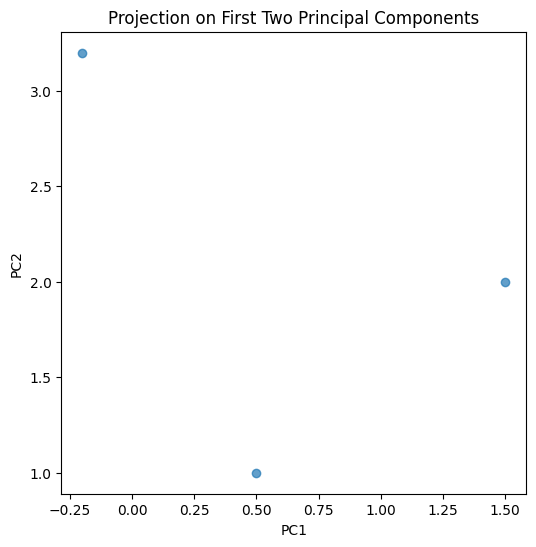

In [37]:
X_proj_data = [
        [0.5, 1.0],
        [1.5, 2.0],
        [-0.2, 3.2]
    ]
X_proj = Matrix(X_proj_data)

fig = plot_pca_projection(X_proj)
plt.show()

## Применение и иследование PCA

### 4.3 Задание (Expert): Исследовать влияние шума на PCA:

In [38]:
import math, random

def add_noise_and_compare(X: 'Matrix', noise_level: float = 0.1) -> None:
    """
    Выполняет PCA до и после добавления гауссовского шума к столбцам матрицы X.
    Выводит информацию о числе компонент и объяснённой дисперсии.
    """
    # Размерность
    num_samples, num_features = X.rows, X.cols

    # ----- PCA на оригинальных данных -----
    proj_orig, var_ratio_orig, k_orig = pca(X)
    print(f"[Original]    k = {k_orig}, explained variance = {var_ratio_orig:.4f}")

    # ----- Статистика по столбцам для шума -----
    # собираем значения каждого столбца
    columns = [X.col(j) for j in range(num_features)]
    # вычисляем среднее и СКО
    means = []
    sigmas = []
    for col_vals in columns:
        mean_val = sum(col_vals) / num_samples
        means.append(mean_val)
        # дисперсия по образцу
        sq_diff = 0.0
        for v in col_vals:
            sq_diff += (v - mean_val) ** 2
        sigma = math.sqrt(sq_diff / (num_samples - 1)) if num_samples > 1 else 0.0
        sigmas.append(sigma)

    # ----- Создаем зашумлённую копию -----
    X_noisy = X.copy()
    for i in range(num_samples):
        for j in range(num_features):
            noise = random.gauss(0.0, sigmas[j] * noise_level)
            original_value = X_noisy[i, j]
            X_noisy.set(i, j, original_value + noise)

    # ----- PCA на зашумленных данных -----
    proj_noisy, var_ratio_noisy, k_noisy = pca(X_noisy)
    print(f"[With Noise]  k = {k_noisy}, explained variance = {var_ratio_noisy:.4f}")

    # ----- Сравнение результатов -----
    delta = var_ratio_noisy - var_ratio_orig
    print(f"Variance change: {delta:+.4f}")
    print("--------------------------------------------")

In [39]:
X_test = Matrix([
        [1.0, 2.0, 3.0],
        [1.5, 2.2, 2.9],
        [2.0, 2.5, 3.2],
        [4.0, 5.0, 6.0],
        [4.1, 5.2, 5.8],
        [4.2, 5.2, 5.9],
        [7.2, 8.2, 8.9],
        [7.5, 8.1, 8.7],
        [7.8, 8.3, 8.8],
        [7.9, 8.2, 8.5],
    ])

add_noise_and_compare(X_test, noise_level=0.2)

[Original]    k = 1, explained variance = 0.9958
[With Noise]  k = 1, explained variance = 0.9679
Variance change: -0.0279
--------------------------------------------


### Дополниительные функции для обучения модели

In [40]:
def train_test_split(X: Matrix, y: Matrix, test_size: float = 0.2, shuffle: bool = True):
    """
    Разбивает данные X и метки y на обучающую и тестовую выборки.

    Параметры:
      X         — Matrix размером n×m
      y         — Matrix размером n×1
      test_size — доля данных для теста (0 < test_size < 1)
      shuffle   — перемешивать ли перед разбиением

    Возвращает:
      X_train, y_train, X_test, y_test — четыре матрицы
    """
    total_rows = X.rows
    row_indices = list(range(total_rows))

    # Перемешивание индексов при необходимости
    if shuffle:
        random.shuffle(row_indices)

    # Определяем точку раздела
    split_point = int(total_rows * (1 - test_size))
    train_indices = row_indices[:split_point]
    test_indices = row_indices[split_point:]

    # Вспомогательная функция для извлечения подматрицы
    def get_subset(mat: Matrix, indices: list) -> Matrix:
        extracted = []
        for r in indices:
            current_row = []
            for c in range(mat.cols):
                current_row.append(mat[r, c])
            extracted.append(current_row)
        return Matrix(extracted)

    X_train = get_subset(X, train_indices)
    y_train = get_subset(y, train_indices)
    X_test = get_subset(X, test_indices)
    y_test = get_subset(y, test_indices)

    return X_train, y_train, X_test, y_test


In [41]:
def separate_features_target(data_matrix: Matrix) -> Tuple[Matrix, Matrix]:
    """
    Делит входную матрицу на признаки и целевую переменную:
    - X: все столбцы, кроме последнего
    - y: последний столбец в виде отдельной матрицы
    """
    total_rows = data_matrix.rows
    total_cols = data_matrix.cols

    features = []
    targets = []

    for row_index in range(total_rows):
        # собираем значения всех признаков текущей строки
        feat_row = []
        for col_index in range(total_cols - 1):
            feat_row.append(data_matrix[row_index, col_index])
        features.append(feat_row)

        # вытаскиваем целевой столбец
        last_val = data_matrix[row_index, total_cols - 1]
        targets.append([last_val])

    X = Matrix(features)
    y = Matrix(targets)
    return X, y


In [42]:
def solve_system(A: Matrix, B: Matrix) -> List[float]:
    """
    Решает систему линейных уравнений A x = B методом Гаусса.
    Возвращает плоский список значений x.
    """
    # Получаем список решений в виде столбцового вектора
    solutions = gauss_solver(A, B)
    if not solutions:
        return []
    vector = solutions[0]

    # Преобразуем Matrix (n×1) в обычный список float
    result = []
    for row_idx in range(vector.rows):
        result.append(vector[row_idx, 0])
    return result

In [43]:
def transform_pca(X: Matrix, W: Matrix, means: List[float]) -> Matrix:
    """
    Применяет обученные параметры PCA к новым данным:
    - центрирует X по вектору means
    - проецирует на компоненты через умножение на W

    Аргументы:
      X     — Matrix размером n×m (новые образцы)
      W     — Matrix размером m×k (матрица весов из PCA)
      means — список длины m, содержащий средние обучающих признаков

    Возвращает:
      Matrix n×k — проекция новых данных
    """
    num_rows = X.rows
    num_cols = X.cols

    # Центрирование по обученным средним
    centered = []
    for r in range(num_rows):
        centered_row = []
        for c in range(num_cols):
            value = X[r, c] - means[c]
            centered_row.append(value)
        centered.append(centered_row)
    centered_matrix = Matrix(centered)

    # Проецируем на пространство главных компонент
    projected = centered_matrix @ W
    return projected

In [44]:
def add_intercept_column(X: Matrix) -> Matrix:
    """
    Расширяет матрицу X добавлением столбца единиц слева.
    На вход X размером n×m, возвращает Matrix размером n×(m+1).
    """
    augmented_rows = []
    for r in X.data:
        # вставляем 1.0 в начало каждой строки
        new_row = [1.0]
        new_row.extend(r)
        augmented_rows.append(new_row)
    return Matrix(augmented_rows)


def train_linear_regression(X: Matrix, y: Matrix) -> Matrix:
    """
    Обучает линейную регрессию через нормальное уравнение:
      w = (X_aug^T X_aug)^{-1} X_aug^T y
    Возвращает вектор весов w размером (m+1)×1.
    """
    # Формируем матрицу признаков с интерсептом
    X_aug = add_intercept_column(X)

    # Матрицы для нормального уравнения
    Xt = X_aug.transpose()
    gram = Xt @ X_aug       # (m+1)×(m+1)
    rhs = Xt @ y            # (m+1)×1

    # Решаем систему gram * w = rhs
    coeffs = solve_system(gram, rhs)  # список float длины m+1

    # Преобразуем в столбцовую матрицу
    w_matrix = Matrix([[c] for c in coeffs])
    return w_matrix


def predict_linear_regression(X: Matrix, w: Matrix) -> Matrix:
    """
    Делает прогноз по модели линейной регрессии:
      y_pred = X_aug @ w
    """
    # Добавляем столбец единиц
    X_aug = add_intercept_column(X)
    # Вычисляем прогнозы
    predictions = X_aug @ w  # возвращает Matrix n×1
    return predictions


def mse(y_true: Matrix, y_pred: Matrix) -> float:
    """
    Вычисляет среднеквадратичную ошибку между y_true и y_pred.
    Ожидаются оба размера n×1.
    """
    n = y_true.rows
    if y_pred.rows != n or y_pred.cols != 1:
        raise ValueError("Размеры y_true и y_pred должны совпадать и быть столбцами")

    # Сумма квадратов отклонений
    total_sq_err = 0.0
    for idx in range(n):
        diff = y_true[idx, 0] - y_pred[idx, 0]
        total_sq_err += diff * diff

    # Возвращаем среднее
    return total_sq_err / n

### 4.4. Задание (Expert): Применить PCA к реальному датасету

Считывания далтасета

In [45]:
def load_iris_csv(file_path: str) -> 'Matrix':
    """
    Загружает набор Iris из CSV-файла.
    Возвращает данные в виде Matrix, где последний столбец — числовая метка вида.
    """
    # Маппинг названий классов на числа
    label_map = {
        "Iris-setosa": 1,
        "Iris-versicolor": 2,
        "Iris-virginica": 3
    }
    rows: List[List[float]] = []

    with open(file_path, mode='r', encoding='utf-8') as f:
        csv_reader = csv.reader(f)
        # Пропускаем заголовок
        next(csv_reader, None)

        for line in csv_reader:
            # Ожидаем минимум 6 полей: id + 4 признака + label
            if len(line) < 6:
                continue
            try:
                # Парсим поля
                idx = int(line[0])
                features = [float(x) for x in line[1:5]]
                species_str = line[5]
                label = label_map.get(species_str)
                if label is None:
                    continue

                # Формируем строку: [id, feat1..feat4, label]
                record = [idx] + features + [label]
                rows.append(record)
            except (ValueError, IndexError):
                # Если парсинг не удался — пропускаем строку
                continue

    return Matrix(rows)

Применение Логистической регрессии вместе с PCA

In [46]:
def pca_from_lr(X: Matrix, k: int = None, threshold: float = 0.95) -> Tuple[Matrix, float, int, Matrix, List[float]]:
    """
    Выполняет PCA и возвращает:
      - X_proj: проекция (n×k)
      - explained_var: доля объяснённой дисперсии
      - k_final: число компонент
      - W: матрица собственных векторов (m×k)
      - means: вектор средних по признакам
    """
    n_samples, n_features = X.rows, X.cols

    # 1) Средние и центрирование
    means = [sum(X.col(j)) / n_samples for j in range(n_features)]
    centered = Matrix([[X[i,j] - means[j] for j in range(n_features)]
                       for i in range(n_samples)])

    # 2) Ковариационная матрица
    C = covariance_matrix(centered)

    # 3) Собственные значения и векторы
    eig_vals = find_eigenvalues(C, tol=1e-6)
    eig_vecs = find_eigenvectors(C, eig_vals)

    # 4) Сортируем по убыванию собственных значений
    indices = list(range(len(eig_vals)))
    for a in range(len(indices)-1):
        for b in range(a+1, len(indices)):
            if eig_vals[indices[b]] > eig_vals[indices[a]]:
                indices[a], indices[b] = indices[b], indices[a]

    sorted_vals = [eig_vals[i] for i in indices]
    sorted_vecs = [eig_vecs[i] for i in indices]

    # 5) Выбираем k
    if k is None:
        k = auto_select_k(sorted_vals, threshold)
    # гарантируем 1 ≤ k ≤ числу найденных значений
    k = max(1, min(k, len(sorted_vals)))

    # 6) Строим W (m×k)
    W = Matrix([[sorted_vecs[j][i,0] for j in range(k)]
                for i in range(n_features)])

    # 7) Проекция
    X_proj = centered @ W

    # 8) Объяснённая дисперсия
    total_variance = sum(sorted_vals)
    explained = sum(sorted_vals[:k])
    explained_var = explained/total_variance if abs(total_variance)>1e-14 else 1.0

    return X_proj, explained_var, k, W, means

Применение PCA к датасету

In [47]:
def apply_pca_to_dataset(dataset_path: str, k: int) -> Tuple[Matrix, float]:
    """
    Загружает CSV, выполняет разделение, PCA и линейную регрессию,
    сравнивает качество до и после снижения размерности.

    Параметры:
      dataset_path — путь к файлу CSV с данными Iris
      k            — число компонент для PCA

    Возвращает:
      X_proj — проекция всех образцов (n×k)
      gamma  — доля объяснённой дисперсии при выборе k компонент
    """
    # 1) Загрузка и распаковка набора данных
    full_matrix = load_iris_csv(dataset_path)
    features, target = separate_features_target(full_matrix)

    # 2) Формирование списков объектов для разбиения
    num_samples = features.rows
    feature_rows = [features.row(i) for i in range(num_samples)]
    target_rows = [target.row(i) for i in range(num_samples)]

    # 3) Делим вручную на train/test (80/20)
    split_pt = int(num_samples * 0.8)
    X_tr = Matrix(feature_rows[:split_pt])
    X_te = Matrix(feature_rows[split_pt:])
    y_tr = Matrix(target_rows[:split_pt])
    y_te = Matrix(target_rows[split_pt:])

    # 4) PCA на обучающей части
    X_tr_proj, explained_var, used_k, W, mu = pca_from_lr(X_tr, k)

    # 5) Преобразуем тестовые данные по тем же компонентам
    X_te_proj = transform_pca(X_te, W, mu)

    # 6) Обучение и оценка линейной регрессии без PCA
    w_plain = train_linear_regression(X_tr, y_tr)
    y_pred_plain = predict_linear_regression(X_te, w_plain)
    mse_plain = mse(y_te, y_pred_plain)

    # 7) Обучение и оценка с PCA-признаками
    w_pca = train_linear_regression(X_tr_proj, y_tr)
    y_pred_pca = predict_linear_regression(X_te_proj, w_pca)
    mse_pca = mse(y_te, y_pred_pca)

    # 8) Вывод результатов
    print(f"Dataset: {dataset_path}")
    print(f"Original shape: ({features.rows}, {features.cols})")
    print(f"PCA components: k={used_k}, explained variance={explained_var:.4f}")
    print(f"Projected shape: ({X_tr_proj.rows + X_te_proj.rows}, {used_k})")
    print("Regression MSE:")
    print(f"  Without PCA: {mse_plain:.4f}")
    print(f"  With    PCA: {mse_pca:.4f}")

    # 9) Возвращаем проекцию всего набора и долю дисперсии
    all_proj = Matrix([*X_tr_proj.data, *X_te_proj.data])
    return all_proj, explained_var

Тестирование времени поиска собственных значений

In [48]:
import time
import matplotlib.pyplot as plt
import random

def generate_random_matrix(n: int) -> Matrix:
    """
    Возвращает Matrix размера n×n с равномерно распределёнными случайными числами [0,1).
    """
    data = []
    for i in range(n):
        row = []
        for j in range(n):
            row.append(random.random())
        data.append(row)
    return Matrix(data)


def test_time_find_eigen(max_n: int = 50, step: int = 10) -> None:
    """
    Измеряет время выполнения функции find_eigenvalues
    для квадратных матриц размерности от step до max_n с шагом step.
    Строит график зависимости времени от n.
    """
    sizes = []
    times = []

    n = step
    while n <= max_n:
        M = generate_random_matrix(n)
        t0 = time.time()
        _ = find_eigenvalues(M)
        t1 = time.time()
        elapsed = t1 - t0
        sizes.append(n)
        times.append(elapsed)
        print(f"n={n}, time={elapsed:.4f} s")
        n += step

    # Построение графика
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(sizes, times, marker='o')
    ax.set_xlabel('Matrix dimension n')
    ax.set_ylabel('Execution time (s)')
    ax.set_title('Time complexity of find_eigenvalues')
    ax.grid(True)
    plt.show()


n=5, time=0.0458 s
n=10, time=0.1317 s
n=15, time=0.3447 s
n=20, time=0.6699 s
n=25, time=1.2447 s


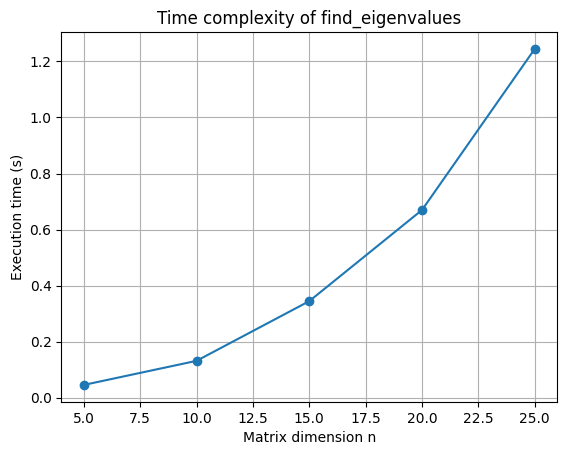

In [49]:
test_time_find_eigen(max_n=25, step=5)

In [51]:
apply_pca_to_dataset('/content/Iris.csv', k = 2)

Dataset: /content/Iris.csv
Original shape: (150, 5)
PCA components: k=1, explained variance=1.0000
Projected shape: (150, 1)
Regression MSE:
  Without PCA: 0.0420
  With    PCA: 1.5625


(<__main__.Matrix at 0x7f847852c210>, 1.0)